In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/test_video

/content/drive/MyDrive/test_video


In [ ]:
import cv2

cap = cv2.VideoCapture('sintel_trailer-1080p.mp4')
w  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
h  = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = cap.get(cv2.CAP_PROP_FPS)
n   = cap.get(cv2.CAP_PROP_FRAME_COUNT)
cap.release()

print(f"Resolution: {w:.0f}×{h:.0f}, FPS: {fps:.2f}, Frames: {int(n)}, Duration: {n/fps:.1f}s")


Resolution: 1920×1080, FPS: 24.00, Frames: 1253, Duration: 52.2s


In [ ]:
import cv2
import os

video_path = 'sintel_trailer-1080p.mp4'
frames_dir = 'frames'
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1
    frame_path = os.path.join(frames_dir, f'frame_{frame_idx:04d}.png')
    cv2.imwrite(frame_path, frame)

cap.release()
print(f"Extracted {frame_idx} frames to '{frames_dir}/'")


KeyboardInterrupt: 

In [ ]:
import glob
import os
import shutil

frames_dir   = 'frames'
triplets_dir = 'triplet_samples'
os.makedirs(triplets_dir, exist_ok=True)

frame_paths = sorted(glob.glob(os.path.join(frames_dir, 'frame_*.png')))
num_frames  = len(frame_paths)

for idx in range(1, num_frames - 1):
    seq_folder = os.path.join(triplets_dir, f'{idx-1:04d}')
    os.makedirs(seq_folder, exist_ok=True)
    # I0, I1, I2
    shutil.copy(frame_paths[idx-1], os.path.join(seq_folder, 'I0.png'))
    shutil.copy(frame_paths[idx],   os.path.join(seq_folder, 'I1.png'))
    shutil.copy(frame_paths[idx+1], os.path.join(seq_folder, 'I2.png'))

print(f"Created {num_frames - 2} triplets in '{triplets_dir}/'")


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir should contain one subfolder per sequence,
        each subfolder with files I0.png, I1.png, I2.png.
        """
        self.root = root_dir
        self.seqs = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        seq_path = os.path.join(self.root, seq)
        I0 = Image.open(os.path.join(seq_path, 'I0.png')).convert('RGB')
        I2 = Image.open(os.path.join(seq_path, 'I2.png')).convert('RGB')

        I0 = TF.to_tensor(I0)
        I2 = TF.to_tensor(I2)

        if self.transform:
            I0, I2 = self.transform(I0), self.transform(I2)

        return I0, I2

triplet_dir = "/content/drive/MyDrive/test_video/triplet_samples"
dataset = TripletDataset(triplet_dir)
loader  = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

print(f"Loaded {len(dataset)} triplets from {triplet_dir}")
for I0, I2 in loader:
    break


In [ ]:
cd /content/drive/MyDrive/Project

/content/drive/.shortcut-targets-by-id/1RN1j56L9z3fCPOXrNwYPRm9tPQ2evdDC/Project


In [ ]:
from models import *
import math
from torchvision.utils import save_image
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import os

device = torch.device("cuda")

student_model = RIFE_Model()
student_model.load_model('ckpt')
student_model.flownet.to(device)

teacher_model = EMA_VFI_Model()
teacher_model.load_model('ours')
teacher_model.eval()
teacher_model.net.to(device)

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


MultiScaleFlow(
  (feature_bone): MotionFormer(
    (block1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=32)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): PReLU(num_parameters=32)
      )
    )
    (patch_embed2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): PReLU(num_parameters=64)
    )
    (block2): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=64)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): PReLU(num_parameters=64)
      )
    )
    (patch_embed3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): PReLU(num_parameters=128)
    )
    (block3): ConvBlock(
      (conv): Sequential(


In [ ]:
from models import RIFE_Model, EMA_VFI_Model
import torch, time, glob, os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── Models ────────────────────────────────────────────────────────────────
student_model = RIFE_Model()
student_model.load_model('ckpt')
student_model.flownet.to(device)
student_model.eval()

teacher_model = EMA_VFI_Model()
teacher_model.load_model('ours')
teacher_model.net.to(device)
teacher_model.eval()

models = {
    'Student': student_model,
    'Teacher': teacher_model,
}

# helper to pick the right inference call
def infer(model, I0, I2):
    if hasattr(model, 'inference_with_flow'):
        return model.inference_with_flow(I0, I2)
    else:
        return model.inference(I0, I2)

# ─── Triplets ─────────────────────────────────────────────────────────────
triplet_dir = "/content/drive/MyDrive/test_video/triplet_samples"
seq_dirs = sorted(
    os.path.join(triplet_dir, d)
    for d in os.listdir(triplet_dir)
    if os.path.isdir(os.path.join(triplet_dir, d))
)
if not seq_dirs:
    raise RuntimeError(f"No subfolders in {triplet_dir}")
print(f"Using {len(seq_dirs)} triplets")

# ─── Benchmark Setup ──────────────────────────────────────────────────────
resolutions = [(256,256), (512,512), (1024,1024)]
results = {name:{'time':[], 'mem':[]} for name in models}
to_tensor = ToTensor()

# ─── Benchmark Loop ───────────────────────────────────────────────────────
for name, model in models.items():
    print(f"\n▶ Benchmarking {name}")
    for H, W in resolutions:
        t_list, m_list = [], []
        for seq in seq_dirs:
            I0 = to_tensor(Image.open(os.path.join(seq,'I0.png'))).unsqueeze(0).to(device)
            I2 = to_tensor(Image.open(os.path.join(seq,'I2.png'))).unsqueeze(0).to(device)
            I0s = F.interpolate(I0, size=(H,W), mode='bilinear', align_corners=False)
            I2s = F.interpolate(I2, size=(H,W), mode='bilinear', align_corners=False)

            torch.cuda.reset_peak_memory_stats(device)
            torch.cuda.synchronize()
            t0 = time.perf_counter()
            with torch.no_grad():
                _ = infer(model, I0s, I2s)
            torch.cuda.synchronize()

            t_list.append(time.perf_counter() - t0)
            m_list.append(torch.cuda.max_memory_allocated(device)/1024**3)

        avg_t = sum(t_list)/len(t_list)
        avg_m = sum(m_list)/len(m_list)
        results[name]['time'].append(avg_t)
        results[name]['mem'].append(avg_m)
        print(f"  {H}×{W}: time={avg_t:.3f}s, mem={avg_m:.2f} GB")

# ─── Plot ─────────────────────────────────────────────────────────────────
plt.figure(figsize=(8,5))
x = [f"{h}×{w}" for h,w in resolutions]
for name, stat in results.items():
    plt.plot(x, stat['time'], marker='o', label=name)
    plt.scatter(x, stat['time'], s=[m*200 for m in stat['mem']], alpha=0.4)

plt.xlabel('Resolution')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time & GPU Memory')
plt.legend()
plt.tight_layout()
plt.show()


Using 1251 triplets

▶ Benchmarking Student


KeyboardInterrupt: 

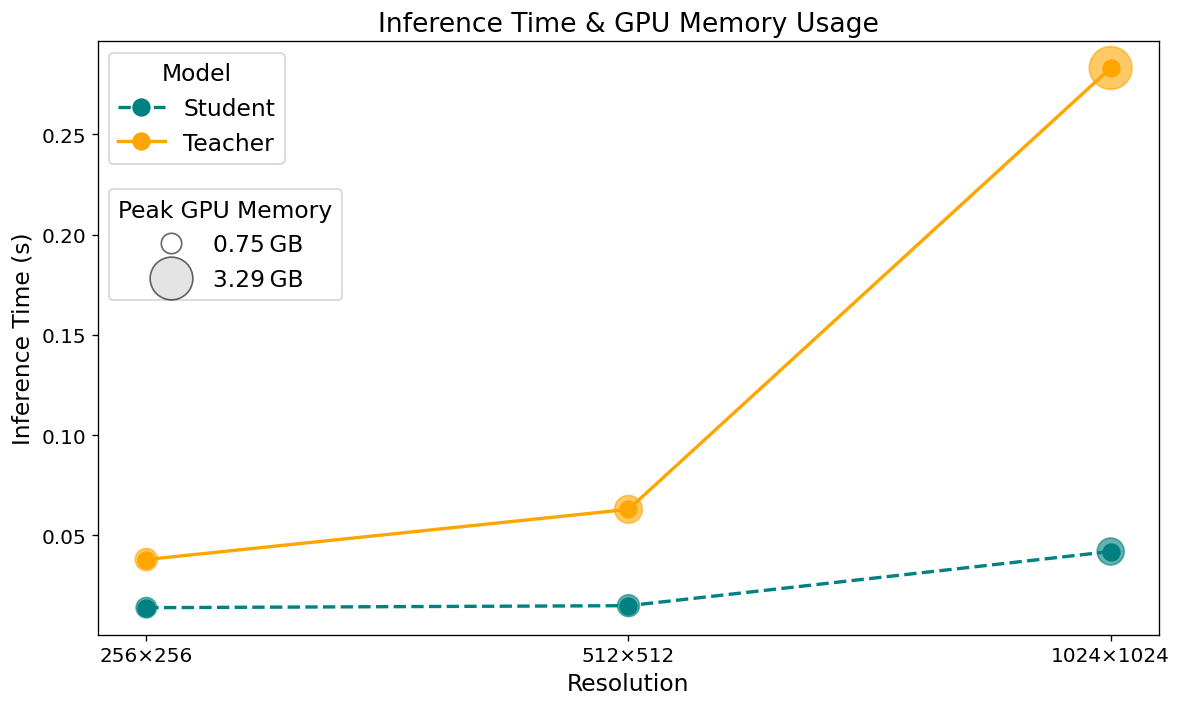

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

resolutions   = ['256×256', '512×512', '1024×1024']
student_time  = [0.014, 0.015, 0.042]
teacher_time  = [0.038, 0.063, 0.283]
student_mem   = [0.75,  0.86,  1.31]
teacher_mem   = [0.88,  1.38,  3.29]

scale = 200
student_sizes = [m * scale for m in student_mem]
teacher_sizes = [m * scale for m in teacher_mem]

all_mem = student_mem + teacher_mem
mem_min, mem_max = min(all_mem), max(all_mem)

fig, ax = plt.subplots(figsize=(10,6), dpi=120)

l1, = ax.plot(resolutions, student_time, '--o', color='teal',   markersize=10, linewidth=2)
l2, = ax.plot(resolutions, teacher_time, '-o', color='orange', markersize=10, linewidth=2)
ax.scatter(resolutions, student_time, s=student_sizes, alpha=0.6, color='teal')
ax.scatter(resolutions, teacher_time, s=teacher_sizes, alpha=0.6, color='orange')

ax.set_xlabel('Resolution', fontsize=14)
ax.set_ylabel('Inference Time (s)', fontsize=14)
ax.set_title('Inference Time & GPU Memory Usage', fontsize=16)
ax.tick_params(labelsize=12)

legend1 = ax.legend(
    handles=[l1, l2],
    labels=['Student', 'Teacher'],
    title='Model',
    title_fontsize=14,
    fontsize=14,
    loc='upper left',
    bbox_to_anchor=(0.01, 0.98),
    borderaxespad=0.
)

small_size = (mem_min * scale) ** 0.5
large_size = (mem_max * scale) ** 0.5
proxy_small = Line2D([0], [0],
                     marker='o', color='black', linestyle='',
                     markersize=small_size, markerfacecolor='white', alpha=0.6)
proxy_large = Line2D([0], [0],
                     marker='o', color='black', linestyle='',
                     markersize=large_size, markerfacecolor='lightgrey', alpha=0.6)

legend2 = ax.legend(
    handles=[proxy_small, proxy_large],
    labels=[f'{mem_min:.2f} GB', f'{mem_max:.2f} GB'],
    title='Peak GPU Memory',
    title_fontsize=14,
    fontsize=14,
    loc='upper left',
    bbox_to_anchor=(0.01, 0.75),
    borderaxespad=0.
)

ax.add_artist(legend1)

plt.tight_layout()
plt.show()


In [ ]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from ipywidgets import interact, IntSlider

from models import RIFE_Model, EMA_VFI_Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

student_model = RIFE_Model()
student_model.load_model('ckpt')
student_model.flownet.to(device).eval()

teacher_model = EMA_VFI_Model()
teacher_model.load_model('ours')
teacher_model.net.to(device).eval()

def infer(model, I0, I2):
    out = model.inference_with_flow(I0, I2) if hasattr(model, 'inference_with_flow') else model.inference(I0, I2)
    return out[0] if isinstance(out, (tuple, list)) else out

to_tensor = ToTensor()
to_pil    = ToPILImage()

triplet_dir = "/content/drive/MyDrive/test_video/triplet_samples"
seqs = sorted(
    d for d in os.listdir(triplet_dir)
    if os.path.isdir(os.path.join(triplet_dir, d))
)
print(f"{len(seqs)} sequences found. Use the slider below to select one.")

def show_sequence(idx=0):
    seq = seqs[idx]
    path = os.path.join(triplet_dir, seq)

    I0 = to_tensor(Image.open(os.path.join(path,'I0.png')).convert('RGB')).unsqueeze(0)
    I1 = to_tensor(Image.open(os.path.join(path,'I1.png')).convert('RGB')).unsqueeze(0)
    I2 = to_tensor(Image.open(os.path.join(path,'I2.png')).convert('RGB')).unsqueeze(0)
    for t in (I0,I1,I2):
        t.resize_(1, *t.shape[1:])
    I0 = F.interpolate(I0, size=(512,512), mode='bilinear', align_corners=False).to(device)
    I1 = F.interpolate(I1, size=(512,512), mode='bilinear', align_corners=False).to(device)
    I2 = F.interpolate(I2, size=(512,512), mode='bilinear', align_corners=False).to(device)

    with torch.no_grad():
        ps = infer(student_model, I0, I2)
        pt = infer(teacher_model, I0, I2)

    I0_p = to_pil(I0[0].cpu())
    I1_p = to_pil(I1[0].cpu())
    I2_p = to_pil(I2[0].cpu())
    ps_p = to_pil(ps[0].cpu())
    pt_p = to_pil(pt[0].cpu())

    fig, ax = plt.subplots(2, 3, figsize=(12,8))
    ax[0,0].imshow(I0_p); ax[0,0].set_title('I0 (input)');       ax[0,0].axis('off')
    ax[0,1].imshow(I1_p); ax[0,1].set_title('I1 (ground-truth)'); ax[0,1].axis('off')
    ax[0,2].imshow(I2_p); ax[0,2].set_title('I2 (input)');       ax[0,2].axis('off')
    ax[1,0].imshow(ps_p); ax[1,0].set_title('Student Pred');     ax[1,0].axis('off')
    ax[1,1].imshow(pt_p); ax[1,1].set_title('Teacher Pred');     ax[1,1].axis('off')
    ax[1,2].imshow(Image.blend(ps_p, pt_p, alpha=0.5))
    ax[1,2].set_title('Overlay (50/50)');                          ax[1,2].axis('off')

    plt.suptitle(f"Sequence #{idx}: {seq}", fontsize=16)
    plt.tight_layout()
    plt.show()

interact(
    show_sequence,
    idx=IntSlider(min=0, max=len(seqs)-1, step=1, value=0, description='Seq #')
)


1251 sequences found. Use the slider below to select one.


interactive(children=(IntSlider(value=0, description='Seq #', max=1250), Output()), _dom_classes=('widget-inte…

<function __main__.show_sequence(idx=0)>

Showing sequence #716: 0716


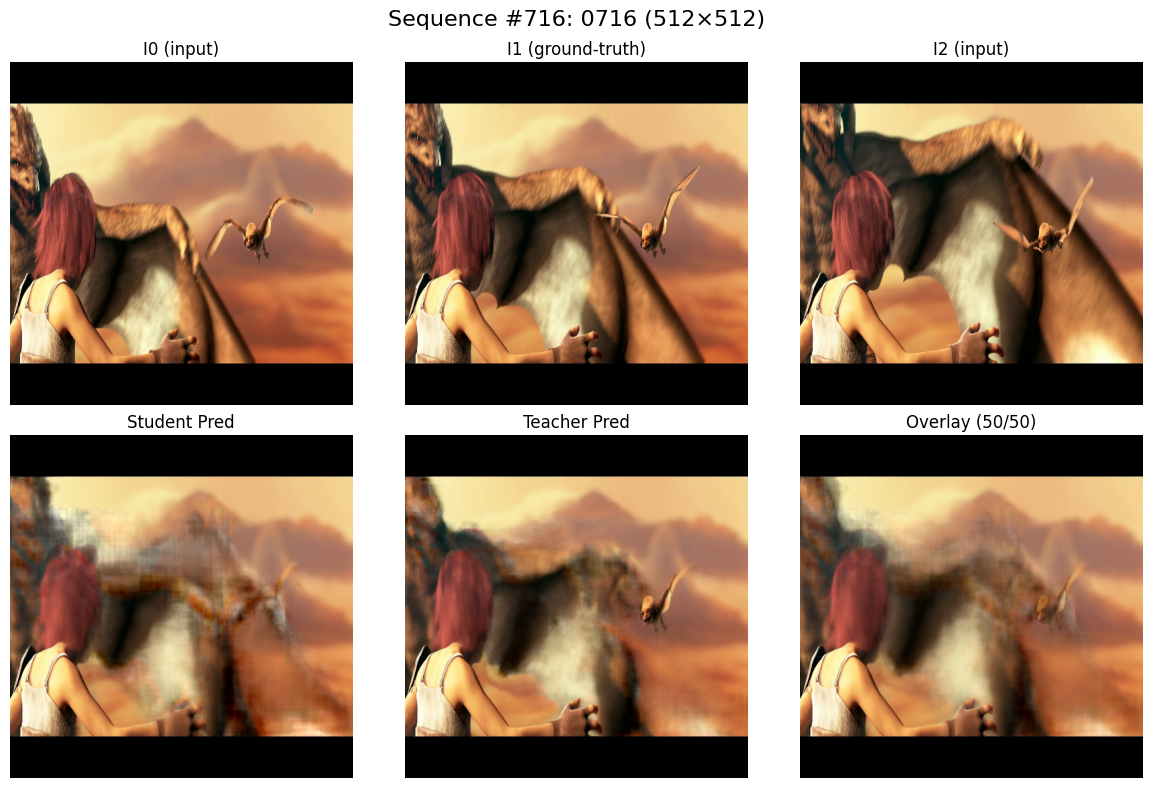

In [ ]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage

from models import RIFE_Model, EMA_VFI_Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

student_model = RIFE_Model()
student_model.load_model('ckpt')
student_model.flownet.to(device).eval()

teacher_model = EMA_VFI_Model()
teacher_model.load_model('ours')
teacher_model.net.to(device).eval()

def infer(model, I0, I2):
    out = model.inference_with_flow(I0, I2) if hasattr(model, 'inference_with_flow') else model.inference(I0, I2)
    return out[0] if isinstance(out, (tuple, list)) else out

to_tensor = ToTensor()
to_pil    = ToPILImage()

triplet_dir = "/content/drive/MyDrive/test_video/triplet_samples"
seqs = sorted(d for d in os.listdir(triplet_dir)
              if os.path.isdir(os.path.join(triplet_dir, d)))

idx = 716
seq = seqs[idx]
seq_path = os.path.join(triplet_dir, seq)
print(f"Showing sequence #{idx}: {seq}")

size = (512, 512)
I0 = to_tensor(Image.open(os.path.join(seq_path,'I0.png')).convert('RGB')).unsqueeze(0)
I1 = to_tensor(Image.open(os.path.join(seq_path,'I1.png')).convert('RGB')).unsqueeze(0)
I2 = to_tensor(Image.open(os.path.join(seq_path,'I2.png')).convert('RGB')).unsqueeze(0)

I0 = F.interpolate(I0, size=size, mode='bilinear', align_corners=False).to(device)
I1 = F.interpolate(I1, size=size, mode='bilinear', align_corners=False).to(device)
I2 = F.interpolate(I2, size=size, mode='bilinear', align_corners=False).to(device)

with torch.no_grad():
    pred_s = infer(student_model, I0, I2)
    pred_t = infer(teacher_model, I0, I2)

I0_p = to_pil(I0[0].cpu())
I1_p = to_pil(I1[0].cpu())
I2_p = to_pil(I2[0].cpu())
ps_p = to_pil(pred_s[0].cpu())
pt_p = to_pil(pred_t[0].cpu())

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0,0].imshow(I0_p); ax[0,0].set_title('I0 (input)');       ax[0,0].axis('off')
ax[0,1].imshow(I1_p); ax[0,1].set_title('I1 (ground-truth)');ax[0,1].axis('off')
ax[0,2].imshow(I2_p); ax[0,2].set_title('I2 (input)');       ax[0,2].axis('off')

ax[1,0].imshow(ps_p); ax[1,0].set_title('Student Pred');    ax[1,0].axis('off')
ax[1,1].imshow(pt_p); ax[1,1].set_title('Teacher Pred');    ax[1,1].axis('off')
ax[1,2].imshow(Image.blend(ps_p, pt_p, alpha=0.5))
ax[1,2].set_title('Overlay (50/50)');                        ax[1,2].axis('off')

plt.suptitle(f"Sequence #{idx}: {seq} (512×512)", fontsize=16)
plt.tight_layout()
plt.show()


Generating error heatmaps for sequence #716: 0716


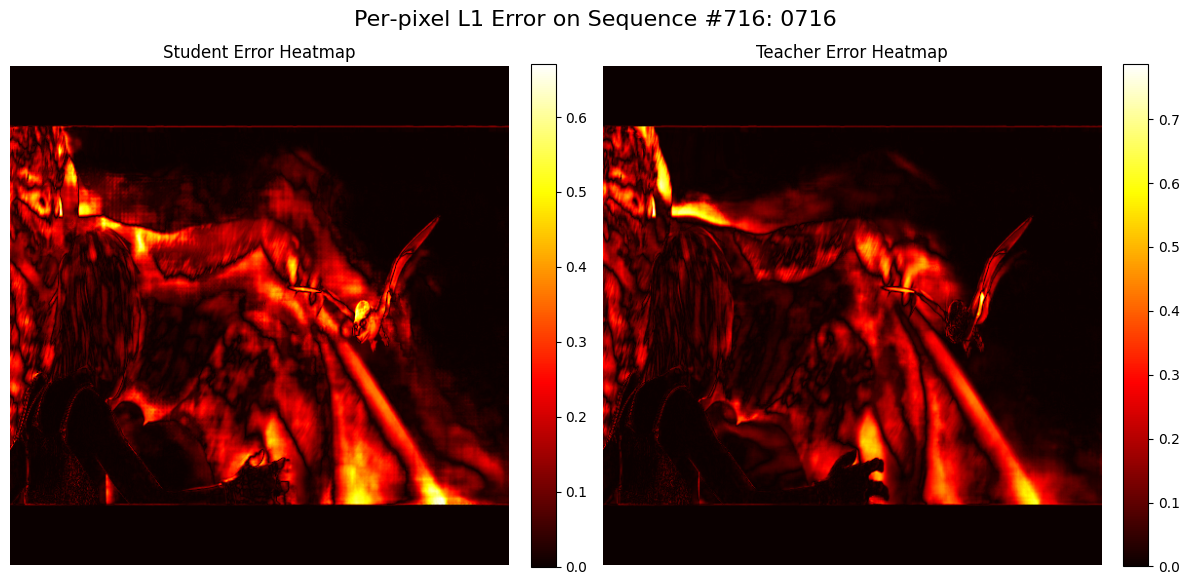

In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
from models import RIFE_Model, EMA_VFI_Model

device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
to_tensor = ToTensor()
resize_to = (512, 512)

student_model = RIFE_Model()
student_model.load_model('ckpt')
student_model.flownet.to(device).eval()

teacher_model = EMA_VFI_Model()
teacher_model.load_model('ours')
teacher_model.net.to(device).eval()

def infer(model, I0, I2):
    out = (model.inference_with_flow(I0, I2)
           if hasattr(model, 'inference_with_flow')
           else model.inference(I0, I2))
    return out[0] if isinstance(out, (tuple, list)) else out

triplet_dir = "/content/drive/MyDrive/test_video/triplet_samples"
seqs = sorted(d for d in os.listdir(triplet_dir)
              if os.path.isdir(os.path.join(triplet_dir, d)))
idx = 716
seq = seqs[idx]
seq_path = os.path.join(triplet_dir, seq)
print(f"Generating error heatmaps for sequence #{idx}: {seq}")

I0 = to_tensor(Image.open(os.path.join(seq_path, 'I0.png')).convert('RGB')).unsqueeze(0)
I1 = to_tensor(Image.open(os.path.join(seq_path, 'I1.png')).convert('RGB')).unsqueeze(0)
I2 = to_tensor(Image.open(os.path.join(seq_path, 'I2.png')).convert('RGB')).unsqueeze(0)

I0 = F.interpolate(I0, size=resize_to, mode='bilinear', align_corners=False).to(device)
I1_np = np.array(
    Image.open(os.path.join(seq_path, 'I1.png')).convert('RGB')
         .resize(resize_to, Image.BILINEAR),
    dtype=np.float32
) / 255.0
I2 = F.interpolate(I2, size=resize_to, mode='bilinear', align_corners=False).to(device)

with torch.no_grad():
    Ps = infer(student_model, I0, I2)[0].cpu().numpy().transpose(1,2,0)
    Pt = infer(teacher_model, I0, I2)[0].cpu().numpy().transpose(1,2,0)

Ps = np.clip(Ps, 0, 1)
Pt = np.clip(Pt, 0, 1)

err_s = np.mean(np.abs(I1_np - Ps), axis=2)
err_t = np.mean(np.abs(I1_np - Pt), axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), dpi=100)

im1 = ax1.imshow(err_s, cmap='hot', vmin=0, vmax=err_s.max())
ax1.set_title('Student Error Heatmap')
ax1.axis('off')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

im2 = ax2.imshow(err_t, cmap='hot', vmin=0, vmax=err_t.max())
ax2.set_title('Teacher Error Heatmap')
ax2.axis('off')
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.suptitle(f"Per‐pixel L1 Error on Sequence #{idx}: {seq}", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
to_tensor = ToTensor()
to_pil    = ToPILImage()
resize_to = (512, 512)

def infer(model, I0, I2):
    out = (model.inference_with_flow(I0, I2)
           if hasattr(model, 'inference_with_flow')
           else model.inference(I0, I2))
    return out[0] if isinstance(out, (tuple,list)) else out

from models import RIFE_Model, EMA_VFI_Model

student_model = RIFE_Model()
student_model.load_model('ckpt')
student_model.flownet.to(device).eval()

teacher_model = EMA_VFI_Model()
teacher_model.load_model('ours')
teacher_model.net.to(device).eval()

triplet_dir = "/content/drive/MyDrive/test_video/triplet_samples"
seqs = sorted(d for d in os.listdir(triplet_dir)
              if os.path.isdir(os.path.join(triplet_dir, d)))

psnr_s, ssim_s = [], []
psnr_t, ssim_t = [], []

for seq in seqs:
    p = os.path.join(triplet_dir, seq)
    I1_img = Image.open(os.path.join(p,'I1.png')).convert('RGB')
    I1_res = I1_img.resize(resize_to, Image.BILINEAR)
    I1_np  = np.array(I1_res, dtype=np.float32) / 255.0

    I0 = to_tensor(Image.open(os.path.join(p,'I0.png')).convert('RGB'))\
            .unsqueeze(0)
    I2 = to_tensor(Image.open(os.path.join(p,'I2.png')).convert('RGB'))\
            .unsqueeze(0)

    I0 = F.interpolate(I0, size=resize_to, mode='bilinear',
                       align_corners=False).to(device)
    I2 = F.interpolate(I2, size=resize_to, mode='bilinear',
                       align_corners=False).to(device)

    with torch.no_grad():
        Ps = infer(student_model, I0, I2)[0].cpu().numpy().transpose(1,2,0)
        Pt = infer(teacher_model, I0, I2)[0].cpu().numpy().transpose(1,2,0)

    Ps = np.clip(Ps, 0, 1)
    Pt = np.clip(Pt, 0, 1)

    psnr_s.append(peak_signal_noise_ratio(I1_np, Ps, data_range=1.0))
    ssim_s.append(structural_similarity(
        I1_np, Ps, data_range=1.0, channel_axis=2))
    psnr_t.append(peak_signal_noise_ratio(I1_np, Pt, data_range=1.0))
    ssim_t.append(structural_similarity(
        I1_np, Pt, data_range=1.0, channel_axis=2))

print(f"Student PSNR: {np.mean(psnr_s):.2f} dB, SSIM: {np.mean(ssim_s):.4f}")
print(f"Teacher PSNR: {np.mean(psnr_t):.2f} dB, SSIM: {np.mean(ssim_t):.4f}")

idx = 744
seq = seqs[idx]
p = os.path.join(triplet_dir, seq)

I1_img = Image.open(os.path.join(p,'I1.png')).convert('RGB')
I1_np  = np.array(I1_img.resize(resize_to, Image.BILINEAR),
                 dtype=np.float32)/255.0

I0 = to_tensor(Image.open(os.path.join(p,'I0.png')).convert('RGB'))\
        .unsqueeze(0)
I2 = to_tensor(Image.open(os.path.join(p,'I2.png')).convert('RGB'))\
        .unsqueeze(0)

I0 = F.interpolate(I0, size=resize_to, mode='bilinear',
                   align_corners=False).to(device)
I2 = F.interpolate(I2, size=resize_to, mode='bilinear',
                   align_corners=False).to(device)

with torch.no_grad():
    Ps = infer(student_model, I0, I2)[0].cpu().numpy().transpose(1,2,0)
Ps = np.clip(Ps, 0, 1)

err = np.mean(np.abs(I1_np - Ps), axis=2)


y, x, w = 150, 100, 200
patch_gt = I1_np[y:y+w, x:x+w]
patch_s  = Ps[y:y+w, x:x+w]

fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].imshow(Ps);         ax[0,0].set_title('Student Prediction'); ax[0,0].axis('off')
ax[0,1].imshow(err, cmap='hot'); ax[0,1].set_title('Error Heatmap');    ax[0,1].axis('off')
ax[1,0].imshow(patch_gt);    ax[1,0].set_title('GT Patch');            ax[1,0].axis('off')
ax[1,1].imshow(patch_s);     ax[1,1].set_title('Student Patch');       ax[1,1].axis('off')
plt.suptitle(f"Error Analysis for Sequence {seq}", fontsize=16)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


KeyboardInterrupt: 